In [1]:
import os, sys
from subprocess import check_output
from functools import partial
import numpy as np, scipy as sp
import pandas as pd
import itertools

import pickle, gc
from datetime import datetime
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, cohen_kappa_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, brier_score_loss
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, RFE, RFECV, chi2, f_classif, f_regression

import xgboost as xgb
import glob, subprocess, copy
import shap
import pyarrow.parquet as pq

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import display, Markdown, Latex
from bokeh.plotting import figure, output_file, show
import seaborn as sns

In [3]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot as plyplot, iplot as plyiplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
from plotly import tools as plytls

In [4]:
import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
torch.manual_seed(19)

In [5]:
cuda = True if torch.cuda.is_available() else False

In [6]:
%%javascript

Jupyter.keyboard_manager.command_shortcuts.add_shortcut('Ctrl-l', {
    help: 'clear output',
    help_index: 'zz',
    handler: function (event) {
        Jupyter.notebook.clear_output();
        return false;
    }
});

Jupyter.keyboard_manager.command_shortcuts.add_shortcut('Ctrl-Shift-l', {
    help: 'clear cells output',
    help_index: 'zz',
    handler: function (event) {
        Jupyter.notebook.clear_cells_output();
        return false;
    }
});

Jupyter.keyboard_manager.command_shortcuts.add_shortcut('Ctrl-z', {
    help: 'undo delete cells',
    help_index: 'zz',
    handler: function (event) {
        Jupyter.notebook.undelete_cell();
        return false;
    }
});

<IPython.core.display.Javascript object>

# Load Data

In [7]:
data_dir = "./"

In [8]:
df_real = pd.read_csv(os.path.join(data_dir, 'all_positive_uniq.csv'), header=0)

In [9]:
vocab =  set(''.join(list(df_real['sequence'])+['-']))

In [10]:
vocab_dict = dict(zip(sorted(list(vocab)), 1+np.arange(len(list(vocab)))))

In [11]:
reverse_vocab_dict = {vocab_dict[x]: x for x in vocab_dict}

In [12]:
ssr = list(df_real['sequence'])

In [13]:
reverse_vocab_dict

{1: '-',
 2: 'A',
 3: 'B',
 4: 'C',
 5: 'D',
 6: 'E',
 7: 'F',
 8: 'G',
 9: 'H',
 10: 'I',
 11: 'K',
 12: 'L',
 13: 'M',
 14: 'N',
 15: 'P',
 16: 'Q',
 17: 'R',
 18: 'S',
 19: 'T',
 20: 'V',
 21: 'W',
 22: 'X',
 23: 'Y',
 24: 'Z'}

## Transform sequence list

In [15]:
seq_len = max([len(x) for x in ssr])

In [16]:
print(seq_len)

25


In [17]:
nsample_real = len(ssr)

In [18]:
vocab_size = len(list(vocab))-1

In [19]:
print(vocab_size)

23


In [20]:
ssrx = [x+'-'*(seq_len-len(x)) for x in ssr]

In [21]:
oh_ssrx = list()
for padded_seq in ssrx:
    oh_padded_seq = [[0]*vocab_size for aa in padded_seq]
    for iaa in range(seq_len):
        aa = padded_seq[iaa]
        enc = vocab_dict[aa]
        if enc <= vocab_size:
            oh_padded_seq[iaa][enc-1]=1
    oh_ssrx.append(oh_padded_seq)

oh_ssrx_arr = np.asarray(oh_ssrx)

In [23]:
print(oh_ssrx_arr.shape)#, oh_ssfx_arr.shape)

(94970, 25, 23)


## Prepare Data

In [24]:
trt_X = np.array(oh_ssrx_arr)
trt_y = np.array([1]*oh_ssrx_arr.shape[0])

In [25]:
trt_X_ts = torch.from_numpy(trt_X.astype('float32'))
trt_y_ts = torch.from_numpy(trt_y)

# Define WGAN-GP

## Define Generator and Discriminator

In [26]:
latent_vector_length = 10

In [27]:
test_latent = torch.rand(5, seq_len, latent_vector_length)

In [28]:
class Generator(nn.Module):
    def __init__(self, input_size, output_size, hidden_size_list, n_steps, layer_class=nn.LSTM, dropout=0):
        super(Generator, self).__init__()
        self.recurrent_layers = [] 
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.n_steps = n_steps
        self.layer_class = layer_class
        self.dropout = dropout
        self.n_hidden_layers = len(hidden_size_list)
        
        # First Hidden Layer
        layer_id = 0
        self.recurrent_layers.append(
            layer_class(input_size=input_size, hidden_size=hidden_size_list[layer_id]
                        , num_layers=1, batch_first=True, dropout=dropout))
        # Other Hidden Layers
        for layer_id in range(1, self.n_hidden_layers):
            self.recurrent_layers.append(
            layer_class(input_size=hidden_size_list[layer_id-1], hidden_size=hidden_size_list[layer_id]
                       , num_layers=1, batch_first=True, dropout=dropout)
            )
        # Last Layer
        self.recurrent_layers.append(
            layer_class(input_size=hidden_size_list[-1], hidden_size=output_size
                       , num_layers=1, batch_first=True, dropout=dropout)
            )
        # Module List
        self.layers = nn.ModuleList(self.recurrent_layers)
        
    def initialization(self, initializer=nn.init.kaiming_normal_):
        for layer in self.recurrent_layers:
            for name, param in layer.named_parameters():
                if 'bias' in name:
                    nn.init.constant_(param, 0.0)
                elif 'weight' in name:
                    initializer(param)
        
    def forward(self, x):
        layer_id = 0
        x = self.recurrent_layers[layer_id](x)
        for layer_id in range(1, self.n_hidden_layers+1):
            x = self.recurrent_layers[layer_id](x[0])
        return x[0]


In [29]:
class Discriminator(nn.Module):
    def __init__(self, input_size, rnn_hidden_size_list, n_steps
                 , dense_hidden_size_list, rnn_layer_class=nn.LSTM, activation=nn.LeakyReLU(0.2, inplace=True)
                 , batchNorm=False, dropout=0):
        super(Discriminator, self).__init__()
        self.rnn_layers = [] 
        self.dense_layers = []
        self.bn_layers = []
        self.input_size = input_size
        self.output_size = 1
        self.rnn_hidden_size_list = rnn_hidden_size_list
        self.dense_hidden_size_list = dense_hidden_size_list
        self.n_steps = n_steps
        self.rnn_layer_class = rnn_layer_class
        self.dropout = dropout
        self.activation = activation
        self.batchNorm = batchNorm
        self.n_rnn_hidden_layers = len(rnn_hidden_size_list)
        self.n_dense_hidden_layers = len(dense_hidden_size_list)
        
        # First Hidden Layer
        rnn_layer_id = 0
        self.rnn_layers.append(
            rnn_layer_class(input_size=input_size, hidden_size=rnn_hidden_size_list[rnn_layer_id]
                        , num_layers=1, batch_first=True, dropout=dropout)
        )
        # Other Hidden Layers
        for rnn_layer_id in range(1, self.n_rnn_hidden_layers):
            self.rnn_layers.append(
            rnn_layer_class(input_size=rnn_hidden_size_list[rnn_layer_id-1], hidden_size=rnn_hidden_size_list[rnn_layer_id]
                       , num_layers=1, batch_first=True, dropout=dropout)
            )
        # Dense Hidden Layers & BN Layers
        dense_layer_id = 0
        self.dense_layers.append(nn.Linear(in_features=rnn_hidden_size_list[rnn_layer_id]*self.n_steps
                            , out_features=dense_hidden_size_list[dense_layer_id]))
        if self.batchNorm:
            self.bn_layers.append(nn.BatchNorm1d(dense_hidden_size_list[dense_layer_id]))
        for dense_layer_id in range(1, self.n_dense_hidden_layers):
            self.dense_layers.append(
                nn.Linear(in_features=dense_hidden_size_list[dense_layer_id-1]
                            , out_features=dense_hidden_size_list[dense_layer_id])
            )
            if self.batchNorm:
                self.bn_layers.append(nn.BatchNorm1d(dense_hidden_size_list[dense_layer_id])) 
        # Output Layer
        self.output_dense_layer = nn.Linear(in_features=dense_hidden_size_list[dense_layer_id], out_features=1)
        # Summary
        if self.batchNorm:
            self.layers = self.rnn_layers + list(zip(self.dense_layers, self.bn_layers)) + [self.output_dense_layer]
        # Module List
        self.layers = nn.ModuleList(self.rnn_layers + self.dense_layers + self.bn_layers)

    def initialization(self, dense_initializer=nn.init.xavier_normal_, rnn_initializer=nn.init.kaiming_normal_):
        for dense_layer in self.dense_layers:
            for name, param in dense_layer.named_parameters():
                if 'bias' in name:
                    nn.init.constant_(param, 0.0)
                elif 'weight' in name:
                    dense_initializer(param)  
        for rnn_layer in self.rnn_layers:
            for name, param in rnn_layer.named_parameters():
                if 'bias' in name:
                    nn.init.constant_(param, 0.0)
                elif 'weight' in name:
                    rnn_initializer(param)        
                    
    def forward(self, x):
        rnn_layer_id = 0
        x = self.rnn_layers[rnn_layer_id](x)
        for rnn_layer_id in range(1, self.n_rnn_hidden_layers):
            x = self.rnn_layers[rnn_layer_id](x[0])
        # print(x[0])
        x = x[0].contiguous().view(-1, self.rnn_hidden_size_list[-1]*self.n_steps)
        for dense_layer_id in range(self.n_dense_hidden_layers):
            x = self.dense_layers[dense_layer_id](x)
            if self.batchNorm:
                x = self.bn_layers[dense_layer_id](x)
            x = self.activation(x)
        out = self.output_dense_layer(x)
        return out


## Define Optim, Loss, etc.
$$
\begin{align*}
L\left(G\right) &= -\mathbb{E}_{x\sim P_g}\left[D\left(x\right)\right] \\
L\left(D\right) &= -\mathbb{E}_{x\sim P_r}\left[D\left(x\right)\right] + \mathbb{E}_{x\sim P_g}\left[D\left(x\right)\right] + \lambda\mathbb{E}_{x\sim \mathfrak{P}_{\hat{x}}}\left[\|\nabla_x D\left(x\right)\|_p-1\right]^2
\end{align*}
$$
where
$$
\hat{x} = \alpha x_r + \left(1-\alpha\right)x_g \\
x_r \sim P_r, x_g \sim P_g, \alpha \sim U\left(0,1\right)
$$


In [30]:
one = torch.FloatTensor([1])
mone = one * -1
if cuda:
    one = one.cuda()
    mone = mone.cuda()

In [31]:
def calc_gradient_penalty(d, real_data, fake_data, ):
    alpha = torch.rand_like(real_data)
    # alpha = alpha.expand(real_data.size())
    alpha = alpha.cuda() if cuda else alpha

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)

    if cuda:
        interpolates = interpolates.cuda()
    interpolates = autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = d(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).cuda() if cuda else torch.ones(
                                  disc_interpolates.size()),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [32]:
G = Generator(input_size=10, output_size=vocab_size, hidden_size_list=[15, 15, 20], n_steps=seq_len)
G.initialization()

In [33]:
D = Discriminator(input_size=vocab_size, rnn_hidden_size_list=[15], n_steps=seq_len, dense_hidden_size_list=[30]
                  , rnn_layer_class=nn.LSTM, activation=nn.LeakyReLU(0.2, inplace=True), batchNorm=True, dropout=0)
D.initialization()

In [34]:
optimizer_D = optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.9))
optimizer_G = optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.9))

## Training

### `torch.util.data.DataLoader`

In [35]:
BATCH_SIZE = 1000

In [36]:
trtset = TensorDataset(torch.from_numpy(trt_X.astype('float32')), torch.from_numpy(trt_y))
trtloader = torch.utils.data.DataLoader(trtset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

### Training Process

In [37]:
N_EPOCHS = 200
N_CRITIC = 3
LAMBDA = 10
MAX_IBATCH = len(trtloader)

In [38]:
loss_tape = []
batch_done = 0
em_tape = []

for epoch in range(N_EPOCHS):
    for ibatch, (_seq, _label) in enumerate(trtloader):
        batch_done += 1
        # ---------------- #
        # Train Critic
        # ---------------- #
        optimizer_D.zero_grad()
        
        real_seq = Variable(_seq)
        fake_vec = Variable(torch.rand(_seq.shape[0], seq_len, latent_vector_length))
        fake_seq = G(fake_vec)
        # All-Real Batch
        real_validity = D(real_seq)
        real_validity = real_validity.mean()
        real_validity.backward(mone)
        # All-Fake Batch
        fake_validity = D(fake_seq)
        fake_validity = fake_validity.mean()
        fake_validity.backward(one)
        # GP Component
        gradient_penalty = calc_gradient_penalty(D, real_seq.data, fake_seq.data)
        gradient_penalty.backward()
        d_loss = -real_validity + fake_validity + LAMBDA * gradient_penalty
        em_distance = real_validity - fake_validity
        #d_loss.backward()
        optimizer_D.step()
        
        # ---------------- #
        # Train Generator
        # ---------------- #
        if (ibatch % N_CRITIC == 0) or (ibatch == MAX_IBATCH):
            optimizer_G.zero_grad()
            fake_vec = Variable(torch.rand(_seq.shape[0], seq_len, latent_vector_length))
            fake_seq = G(fake_vec)
            fake_validity = D(fake_seq)
            g_loss = g_loss = -torch.mean(fake_validity)
            g_loss.backward()
            optimizer_G.step()
            
            loss_tape.append({
                  'epoch': epoch
                , 'batch_done': batch_done
                , 'g_loss': g_loss.item()
                , 'd_loss': d_loss.item()
                , 'em': em_distance.item()
            })
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f][EM Dist: %f]"
                % (epoch, N_EPOCHS, ibatch, len(trtloader), d_loss.item(), g_loss.item(), em_distance.item())
            )

[Epoch 0/200] [Batch 0/95] [D loss: 7.062888] [G loss: -0.000996][EM Dist: 0.001201]
[Epoch 0/200] [Batch 3/95] [D loss: 6.977476] [G loss: -0.000783][EM Dist: 0.000266]
[Epoch 0/200] [Batch 6/95] [D loss: 6.983384] [G loss: 0.000906][EM Dist: 0.000448]
[Epoch 0/200] [Batch 9/95] [D loss: 6.951105] [G loss: -0.001646][EM Dist: 0.001851]
[Epoch 0/200] [Batch 12/95] [D loss: 6.892685] [G loss: -0.001281][EM Dist: 0.000668]
[Epoch 0/200] [Batch 15/95] [D loss: 6.885506] [G loss: -0.000138][EM Dist: -0.001128]
[Epoch 0/200] [Batch 18/95] [D loss: 6.877073] [G loss: -0.001095][EM Dist: 0.000554]
[Epoch 0/200] [Batch 21/95] [D loss: 6.854632] [G loss: 0.000648][EM Dist: -0.000691]
[Epoch 0/200] [Batch 24/95] [D loss: 6.814394] [G loss: 0.000424][EM Dist: 0.000925]
[Epoch 0/200] [Batch 27/95] [D loss: 6.737545] [G loss: 0.001300][EM Dist: -0.000209]
[Epoch 0/200] [Batch 30/95] [D loss: 6.772632] [G loss: 0.002018][EM Dist: -0.002030]
[Epoch 0/200] [Batch 33/95] [D loss: 6.706617] [G loss: 0.0

In [39]:
df_loss = pd.DataFrame(loss_tape).set_index('batch_done')

In [40]:
# df_loss

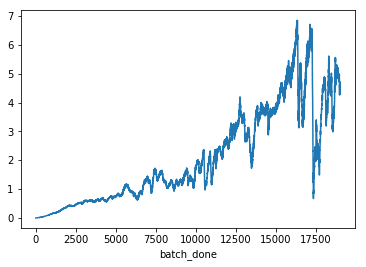

In [41]:
df_loss['g_loss'].plot()

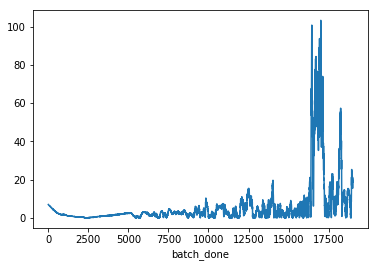

In [42]:
df_loss['d_loss'].abs().plot()

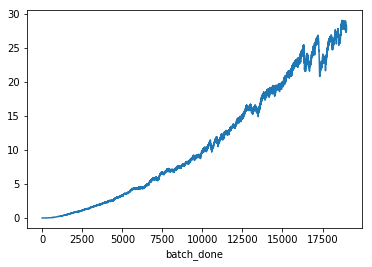

In [43]:
df_loss['em'].abs().plot()

In [44]:
# torch.save(D.state_dict(), PATH)

In [45]:
# torch.save(G.state_dict(), PATH)

## Generate Sequences

In [65]:
ncandidates = 100000
noise = torch.rand(ncandidates, seq_len, latent_vector_length)
g_noise = G(noise)

In [66]:
candidates = g_noise.data.numpy()

In [67]:
pred_seq_array = []
for candidate in candidates:
    encoded_seq = np.argmax(candidate, axis=1)+1
    decoded_seq = [reverse_vocab_dict[x] for x in encoded_seq]
    decoded_seq = [x for x in decoded_seq if x != '-']
    decoded_seq = ''.join(decoded_seq)
    pred_seq_array.append(decoded_seq)

In [69]:
df_pred_seq = \
pd.DataFrame(list(zip(pred_seq_array, [-1]*len(pred_seq_array))), columns=['sequence', 'label'])

In [71]:
# df_pred_seq.to_csv(os.path.join(data_dir, "generated_sequences.csv"), header=True, index=False)